In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.data import Shanghai
from scipy.signal import convolve

In [2]:
sh = Shanghai()
sh.load_data()

In [3]:
sh.I.shape

(103,)

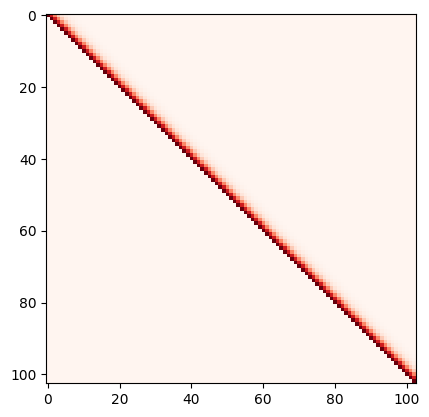

In [50]:
from scipy.stats import gamma

N = sh.C.shape[0]
H = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        H[i, j] = gamma.pdf(j-i+1, 2)
H = np.clip(H, a_min=1e-6, a_max=np.infty)

plt.imshow(H, cmap=plt.cm.Reds)
plt.show()

In [51]:
H

array([[3.67879441e-01, 2.70670566e-01, 1.49361205e-01, ...,
        1.00000000e-06, 1.00000000e-06, 1.00000000e-06],
       [1.00000000e-06, 3.67879441e-01, 2.70670566e-01, ...,
        1.00000000e-06, 1.00000000e-06, 1.00000000e-06],
       [1.00000000e-06, 1.00000000e-06, 3.67879441e-01, ...,
        1.00000000e-06, 1.00000000e-06, 1.00000000e-06],
       ...,
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        3.67879441e-01, 2.70670566e-01, 1.49361205e-01],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        1.00000000e-06, 3.67879441e-01, 2.70670566e-01],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        1.00000000e-06, 1.00000000e-06, 3.67879441e-01]])

In [5]:
H[0, :]

array([1.00000000e-06, 1.01377712e-06, 1.90949253e-04, 2.70050393e-03,
       1.32311917e-02, 3.62655774e-02, 6.88384890e-02, 1.01404670e-01,
       1.24076917e-01, 1.31755640e-01, 1.25110036e-01, 1.08525509e-01,
       8.73643799e-02, 6.60539621e-02, 4.73441737e-02, 3.24071672e-02,
       2.13110624e-02, 1.35291673e-02, 8.32508811e-03, 4.98223513e-03,
       2.90815326e-03, 1.65968818e-03, 9.28031019e-04, 5.09347768e-04,
       2.74834075e-04, 1.45993997e-04, 7.64435011e-05, 3.94966110e-05,
       2.01564366e-05, 1.01690170e-05, 5.07567496e-06, 2.50820641e-06,
       1.22790099e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
      

In [6]:
from numpy.random import poisson

m = np.dot(H.T, sh.C)
obs = poisson(m)

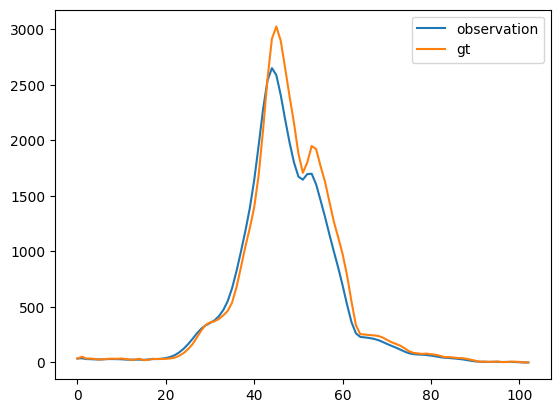

In [57]:
plt.plot(np.dot(H, sh.I), label="observation")
plt.plot(sh.I, label="gt")
plt.legend()

[Warning] Exit without converging for threshold 0.001 with number of iterations             1000. Try increasing the max_iter.


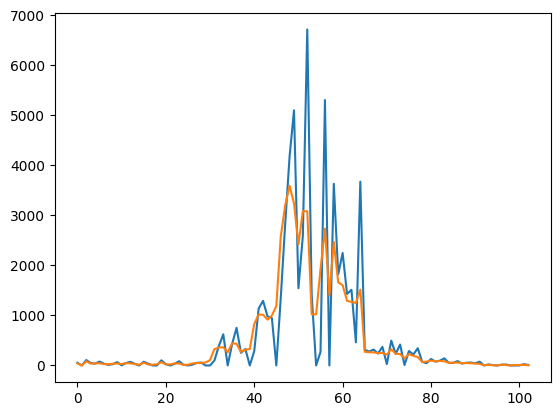

In [54]:
from utils.Richardson_Lucy_Deconvolution import R_L_deconvolve

res = R_L_deconvolve(sh.C, H, max_iter=1000)
plt.plot(res)
plt.plot(sh.C)
plt.show()

[Warning] Exit without converging for threshold 0.001 with number of iterations             1000. Try increasing the max_iter.


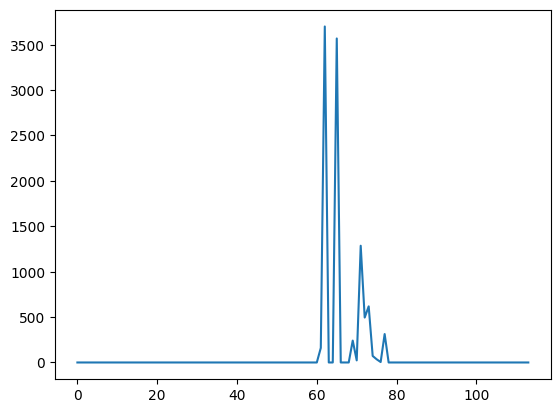

In [30]:
from utils.Richardson_Lucy_Deconvolution import R_L_deconvolve

res = R_L_deconvolve(sh.C_, np.clip(sh.H, a_min=0.04, a_max=np.infty), max_iter=1000)
plt.plot(res)
plt.show()

In [77]:
from utils.Richardson_Lucy_Deconvolution import R_L_deconvolve

res = R_L_deconvolve(sh.C, H, max_iter=1000)

[Warning] Exit without converging for threshold 0.001 with number of iterations             1000. Try increasing the max_iter.


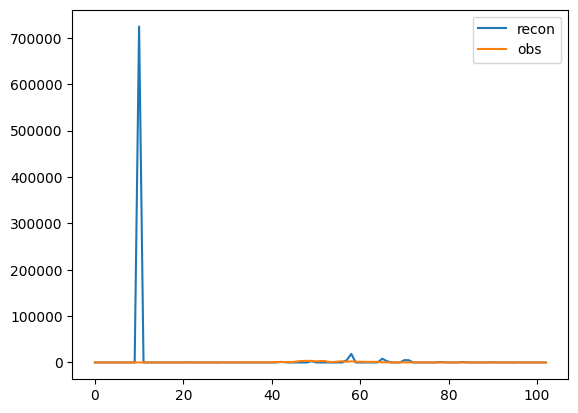

In [79]:
plt.plot(res, label="recon")
plt.plot(sh.C, label="obs")

plt.legend()

In [ ]:
report = sh.C
H = np.zeros((len(report), len(report)))
days = 2
incub = np.ones((days)) / days
N = len(incub)
for i in range(len(report)):
    if i+N+1 <= H.shape[0]:
        H[i, i:i+N] = incub
    else:
        H[i, i:H.shape[0]] = incub[:H.shape[0]-i]

In [32]:
def richardson_lucy(image, psf, iterations=50, clip=True, filter_epsilon=None):
    """Richardson-Lucy deconvolution.
    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray
       The point spread function.
    iterations : int, optional
       Number of iterations. This parameter plays the role of
       regularisation.
    clip : boolean, optional
       True by default. If true, pixel value of the result above 1 or
       under -1 are thresholded for skimage pipeline compatibility.
    filter_epsilon: float, optional
       Value below which intermediate results become 0 to avoid division
       by small numbers.
    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.
    Examples
    --------
    >>> from skimage import img_as_float, data, restoration
    >>> camera = img_as_float(data.camera())
    >>> from scipy.signal import convolve2d
    >>> psf = np.ones((5, 5)) / 25
    >>> camera = convolve2d(camera, psf, 'same')
    >>> camera += 0.1 * camera.std() * np.random.standard_normal(camera.shape)
    >>> deconvolved = restoration.richardson_lucy(camera, psf, 5)
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
    """
    float_type = np.promote_types(image.dtype, np.float32)
    image = image.astype(float_type, copy=False)
    psf = psf.astype(float_type, copy=False)
    im_deconv = np.full(image.shape, 0.5, dtype=float_type)
    psf_mirror = np.flip(psf)

    for _ in range(iterations):
        conv = convolve(im_deconv, psf, mode='same')
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
        else:
            relative_blur = image / conv
        im_deconv *= convolve(relative_blur, psf_mirror, mode='same')

    if clip:
        im_deconv[im_deconv < 0] = 0

    return im_deconv

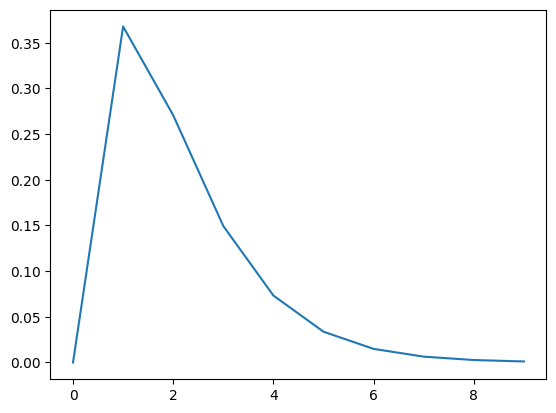

In [58]:
psf = sh.H[0, :][:10]
plt.plot(psf)

In [63]:
res = richardson_lucy(sh.C, np.clip(psf, a_min=0.1, a_max=np.infty))

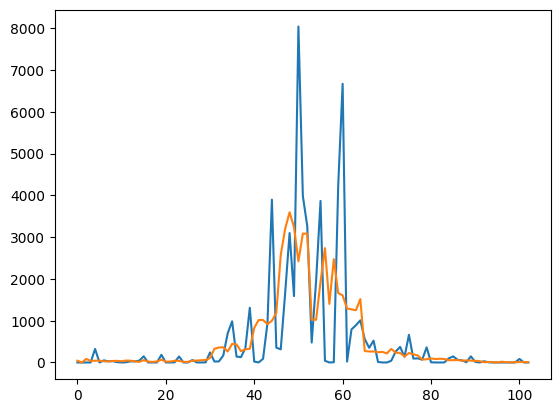

In [64]:
plt.plot(res)
plt.plot(sh.C)